# MMAE 350 — HW3 Companion Notebook  
## Thomas Algorithm (Direct) and Gauss–Seidel (Iterative)

**Purpose:** This notebook is provided to **verify** your hand calculations for HW3 and to explore convergence behavior.  
Complete the required **hand work first**, then use this notebook to check your results.

---

### What you will do
1. Define the matrix **A** and right-hand side **b** from HW3  
2. Solve with:
   - (A) a **Thomas Algorithm** implementation (tridiagonal direct solver)
   - (B) a **Gauss–Seidel** iterative solver
3. Compare against `numpy.linalg.solve`
4. Plot **residual norm** vs iteration for Gauss–Seidel


In [8]:
import numpy as np
import matplotlib.pyplot as plt


## 1) Define the system  $\mathbf{A}\mathbf{x}=\mathbf{d}$

Enter the matrix and vector exactly as in the HW3 PDF.

For HW3 (as written), use:

\begin{equation}
\mathbf{A}=
\begin{bmatrix}
4 & -1 & 0 & 0 \\
-1 & 4 & -1 & 0 \\
0 & -1 & 4 & -1 \\
0 & 0 & -1 & 3
\end{bmatrix},\qquad
\mathbf{d}=
\begin{bmatrix}
15 \\ 10 \\ 10 \\ 10
\end{bmatrix}.
\end{equation}


## Hand Calculation Overview
Here the Thomas Algorithm and two Gauss–Seidel sweeps are carried out by hand (typeset below),
then everything is verified with notebook implementations.


In [9]:
A = np.array([
    [ 4.0, -1.0,  0.0,  0.0],
    [-1.0,  4.0, -1.0,  0.0],
    [ 0.0, -1.0,  4.0, -1.0],
    [ 0.0,  0.0, -1.0,  3.0],
], dtype=float)

d = np.array([15.0, 10.0, 10.0, 10.0], dtype=float)

print("A =\n", A)
print("d =", d)
print("shape(A) =", A.shape)


A =
 [[ 4. -1.  0.  0.]
 [-1.  4. -1.  0.]
 [ 0. -1.  4. -1.]
 [ 0.  0. -1.  3.]]
d = [15. 10. 10. 10.]
shape(A) = (4, 4)


## 2) Reference solution (for checking)

This is *not* the Thomas Algorithm — it's a general-purpose dense solver.
Use it as a reference to confirm your other results.


In [10]:
x_ref = np.linalg.solve(A, d)
print("Reference solution (numpy.linalg.solve):")
print(x_ref)


Reference solution (numpy.linalg.solve):
[5. 5. 5. 5.]


## 3) Thomas Algorithm (Tridiagonal Direct Solver)

The Thomas Algorithm expects the three diagonals:

- `lower[i] = A[i+1, i]` (length \(n-1\))
- `main[i]  = A[i, i]`   (length \(n\))
- `upper[i] = A[i, i+1]` (length \(n-1\))

### Your task
- Extract the diagonals from `A`
- Solve using `thomas_solve(...)`

> If your hand work is correct, the Thomas solution should match the reference solution.


### Problem 1(a–c) — Thomas Algorithm by Hand

We are given the tridiagonal system $A x = d$ with

\begin{equation}
A=
\begin{bmatrix}
4 & -1 & 0 & 0 \\
-1 & 4 & -1 & 0 \\
0 & -1 & 4 & -1 \\
0 & 0 & -1 & 3
\end{bmatrix},
\qquad
d=
\begin{bmatrix}
15 \\ 10 \\ 10 \\ 10
\end{bmatrix}.
\end{equation}

Using the notation from class:

- $a_i$ = subdiagonal entries  
- $b_i$ = diagonal entries  
- $c_i$ = superdiagonal entries  
- $d_i$ = right-hand side entries  

With 0-based indexing:

\begin{equation}
a_1=a_2=a_3=-1,\qquad
b_0=b_1=b_2=4,\ b_3=3,\qquad
c_0=c_1=c_2=-1.
\end{equation}

---

## Forward Sweep (Thomas Algorithm)

We compute modified coefficients $b_i', d_i'$ using multipliers $m_i$.

For $i=0$:

\begin{equation}
m_0 = 0,
\qquad
b_0' = b_0,
\qquad
c_0' = c_0,
\qquad
d_0' = d_0.
\end{equation}

For $i=1,2,3$:

\begin{equation}
m_i = \frac{a_i}{b_{i-1}'},
\qquad
b_i' = b_i - m_i c_{i-1},
\qquad
c_i' = c_i,
\qquad
d_i' = d_i - m_i d_{i-1}'.
\end{equation}

### Forward-Sweep Table (Thomas; unnormalized, with $c_i' = c_i$)

\begin{equation}
\begin{array}{c|c|c|c|c}
i & m_i & b_i' & c_i & d_i' \\\hline
0 & 0 & 4.0000000 & -1 & 15.0000000 \\
1 & -0.2500000 & 3.7500000 & -1 & 13.7500000 \\
2 & -0.2666667 & 3.7333333 & -1 & 13.6666667 \\
3 & -0.2678571 & 2.7321429 & 0  & 13.6607143
\end{array}
\end{equation}

## Back Substitution (Unnormalized Thomas Form)

Using the previously computed value

\begin{equation}
x_3=\frac{d_3'}{b_3'} = 5,
\end{equation}

we apply the recursive formula

\begin{equation}
x_i = \frac{d_i' - c_i x_{i+1}}{b_i'}.
\end{equation}

Proceeding upward:

\begin{equation}
x_2
= \frac{13.6666667 - (-1)(5)}{3.7333333}
= 5,
\end{equation}

\begin{equation}
x_1
= \frac{13.7500000 - (-1)(5)}{3.7500000}
= 5,
\end{equation}

\begin{equation}
x_0
= \frac{15.0000000 - (-1)(5)}{4.0000000}
= 5.
\end{equation}

\begin{equation}
\boxed{x = [5,\ 5,\ 5,\ 5]^T}
\end{equation}

In [11]:
def extract_tridiagonals(A):
    # Extract lower, main, upper diagonals from a tridiagonal matrix A.
    A = np.asarray(A, dtype=float)
    lower = np.diag(A, k=-1).copy()
    main  = np.diag(A, k=0).copy()
    upper = np.diag(A, k=1).copy()
    return lower, main, upper

lower, main, upper = extract_tridiagonals(A)
print("lower =", lower)
print("main  =", main)
print("upper =", upper)

type(lower)

lower = [-1. -1. -1.]
main  = [4. 4. 4. 3.]
upper = [-1. -1. -1.]


numpy.ndarray

### Provided Thomas solver


In [16]:
def thomas_solve(lower, main, upper, d):
    """
    Solve Ax = b for a tridiagonal matrix using the Thomas algorithm.

    Uses:
      m_i   = lower[i-1] / b'_{i-1}
      b'_i  = main[i] - m_i * upper[i-1]
      d'_i  = b[i] - m_i * d'_{i-1}

    Assumes:
      - lower has length n-1
      - main  has length n
      - upper has length n-1
      - no zero pivots
    """
    lower = np.asarray(lower, dtype=float)
    main  = np.asarray(main,  dtype=float)
    upper = np.asarray(upper, dtype=float)
    d     = np.asarray(d,     dtype=float)

    n = main.size

    # Allocate modified coefficients
    b_prime = np.zeros(n)
    d_prime = np.zeros(n)

    # --- Forward sweep ---
    b_prime[0] = main[0]
    d_prime[0] = d[0]

    for i in range(1, n):
        m = lower[i-1] / b_prime[i-1]
        b_prime[i] = main[
            i] - m * upper[i-1]
        d_prime[i] = d[i] - m * d_prime[i-1]

    # --- Back substitution ---
    x = np.zeros(n)
    x[-1] = d_prime[-1] / b_prime[-1]

    for i in range(n-2, -1, -1):
        x[i] = (d_prime[i] - upper[i] * x[i+1]) / b_prime[i]

    return x

In [17]:
x_thomas = thomas_solve(lower, main, upper, d)
print("Thomas solution:")
print(x_thomas)

print("\nMax abs difference vs reference:", np.max(np.abs(x_thomas - x_ref)))


Thomas solution:
[5. 5. 5. 5.]

Max abs difference vs reference: 0.0


## 4) Gauss–Seidel Iteration

Gauss–Seidel produces a sequence $x^{(0)}, x^{(1)}, \dots$

Two common stopping checks:
- **Residual-based (preferred):**  $\|r\|/\|b\| < \varepsilon$ where $r=b-Ax$
- **Update-based:** $\|x^{(k+1)}-x^{(k)}\|/\|x^{(k+1)}\| < \varepsilon$

### Your task
Fill in the TODOs in `gauss_seidel(...)`.


### Problem 2(a–b) — Gauss–Seidel Method by Hand

We solve the linear system

\begin{equation}
A x = b,
\end{equation}

where

\begin{equation}
A =
\begin{bmatrix}
4 & -1 & 0 & 0 \\
-1 & 4 & -1 & 0 \\
0 & -1 & 4 & -1 \\
0 & 0 & -1 & 3
\end{bmatrix},
\qquad
b =
\begin{bmatrix}
15 \\ 10 \\ 10 \\ 10
\end{bmatrix}.
\end{equation}

---

## Gauss–Seidel Recursion Formula

For a linear system $Ax=b$, the Gauss–Seidel update for component $i$ is

\begin{equation}
x_i^{(k+1)}
=
\frac{1}{a_{ii}}
\left(
b_i
-
\sum_{j<i} a_{ij} x_j^{(k+1)}
-
\sum_{j>i} a_{ij} x_j^{(k)}
\right).
\end{equation}

This means we use the **newest available values** as soon as they are computed.

---

## Gauss–Seidel Updates for This System

Applying the formula to our matrix gives:

\begin{equation}
x_1 \leftarrow \frac{15 + x_2}{4},
\qquad
x_2 \leftarrow \frac{10 + x_1 + x_3}{4},
\qquad
x_3 \leftarrow \frac{10 + x_2 + x_4}{4},
\qquad
x_4 \leftarrow \frac{10 + x_3}{3}.
\end{equation}

### Problem 2(a–b) — Gauss–Seidel Sweeps by Hand

Use

\begin{equation}
x^{(0)}=\begin{bmatrix}0&0&0&0\end{bmatrix}^T.
\end{equation}

From $Ax=b$, the Gauss–Seidel update equations are:

\begin{equation}
x_1 \leftarrow \frac{15 + x_2}{4}, \qquad
x_2 \leftarrow \frac{10 + x_1 + x_3}{4}, \qquad
x_3 \leftarrow \frac{10 + x_2 + x_4}{4}, \qquad
x_4 \leftarrow \frac{10 + x_3}{3}.
\end{equation}

---

### Sweep 1 (from $x^{(0)}=0$)

\begin{equation}
x_1^{(1)}=\frac{15+0}{4}=3.75,
\qquad
x_2^{(1)}=\frac{10+x_1^{(1)}+0}{4}
=\frac{13.75}{4}
=3.4375,
\end{equation}

\begin{equation}
x_3^{(1)}=\frac{10+x_2^{(1)}+0}{4}
=\frac{13.4375}{4}
=3.359375,
\qquad
x_4^{(1)}=\frac{10+x_3^{(1)}}{3}
=\frac{13.359375}{3}
=4.453125.
\end{equation}

\begin{equation}
x^{(1)}=
\begin{bmatrix}
3.75\\
3.4375\\
3.359375\\
4.453125
\end{bmatrix}.
\end{equation}

---

### Sweep 2

\begin{equation}
x_1^{(2)}=\frac{15+x_2^{(1)}}{4}
=\frac{18.4375}{4}
=4.609375,
\qquad
x_2^{(2)}=\frac{10+x_1^{(2)}+x_3^{(1)}}{4}
=\frac{17.96875}{4}
=4.4921875,
\end{equation}

\begin{equation}
x_3^{(2)}=\frac{10+x_2^{(2)}+x_4^{(1)}}{4}
=\frac{18.9453125}{4}
=4.736328125,
\qquad
x_4^{(2)}=\frac{10+x_3^{(2)}}{3}
=\frac{14.736328125}{3}
=4.912109375.
\end{equation}

\begin{equation}
x^{(2)}=
\begin{bmatrix}
4.609375\\
4.4921875\\
4.736328125\\
4.912109375
\end{bmatrix}.
\end{equation}


In [23]:
def gauss_seidel(A, b, x0, num_sweeps, tol=1e-8):
    """
    Gauss–Seidel iteration for Ax=b.

    Returns
    -------
    x : approximate solution
    rel_residual : list of relative residual values (for plotting)
    """

    A = np.array(A, dtype=float)
    b = np.array(b, dtype=float)
    x = np.array(x0, dtype=float).copy()

    n = len(b)
    rel_residual = []

    # ---- TODO COMPLETED: compute ||b|| for relative residual ----
    bnorm = np.linalg.norm(b)
    if bnorm == 0:
        bnorm = 1.0

    for k in range(num_sweeps):
        for i in range(n):

            s1 = 0.0
            for j in range(i):
                s1 += A[i, j] * x[j]

            s2 = 0.0
            for j in range(i+1, n):
                s2 += A[i, j] * x[j]

            x[i] = (b[i] - s1 - s2) / A[i, i]

        # ---- TODO COMPLETED: compute residual ----
        r = b - A @ x

        # ---- TODO COMPLETED: compute relative residual ----
        rr = np.linalg.norm(r) / bnorm

        # ---- TODO COMPLETED: store residual history for plotting ----
        rel_residual.append(rr)

        # ---- TODO COMPLETED: stopping criterion ----
        if rr < tol:
            break

    # ---- TODO COMPLETED: return residual history along with solution ----
    return x, rel_residual

In [24]:
# Initial guess from HW: x^(0)=0
x0 = np.zeros_like(d)
niter = 50
tol = 1.0e-8

x_gs, rel_res = gauss_seidel(A, d, x0, niter, tol=tol)

print("Gauss–Seidel solution (after stopping):")
print(x_gs)
print("Final relative residual =", rel_res[-1] if len(rel_res)>0 else None)
print("Number of sweeps =", len(rel_res))


Gauss–Seidel solution (after stopping):
[4.99999997 4.99999998 4.99999999 5.        ]
Final relative residual = 4.2160481207255975e-09
Number of sweeps = 12


## 5) Plot: residual norm vs iteration

This plot helps you visualize convergence.


## 6) Table and plot: residual norm vs iteration
We plot the relative residual history $\|r\|/\|b\|$ to visualize convergence.


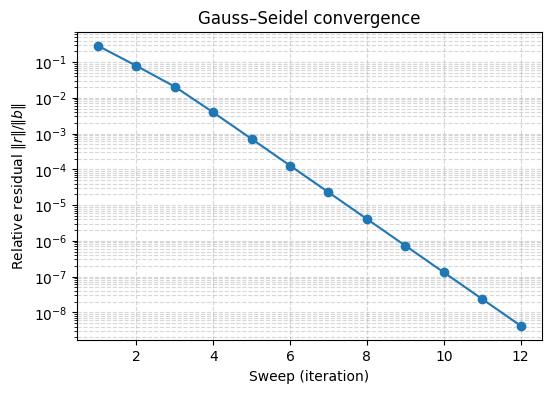

In [25]:
plt.figure(figsize=(6,4))
plt.semilogy(range(1, len(rel_res)+1), rel_res, marker='o')
plt.xlabel("Sweep (iteration)")
plt.ylabel(r"Relative residual $\|r\|/\|b\|$")
plt.title("Gauss–Seidel convergence")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


## 7) Reflection (model answers)
**Why does Gauss–Seidel converge for this system?**
The matrix is strictly diagonally dominant, meaning that in each row the magnitude of the diagonal entry is larger than the sum of the magnitudes of the off-diagonal entries. This is a standard condition that guarantees convergence of the Gauss–Seidel method. Intuitively, the strong diagonal terms ensure that each update is primarily influenced by its own equation, so the iterations tend to move steadily toward the solution rather than oscillating or diverging.

**How does the converged solution compare to the Thomas Algorithm solution?**  
They converge to the same solution (up to roundoff). The Thomas Algorithm gives the exact direct-solve result in a fixed number of operations, while Gauss–Seidel approaches that same result gradually over multiple sweeps.
